# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (11314,)
test label shape: (3766,)
dev label shape: (3766,)
labels names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    for i in range(num_examples):
        print "Example %i :\nText: %s\n\nLabel: %s - %s" % (i+1, train_data[i], train_labels[i], newsgroups_train.target_names[train_labels[i]])
        print "\n================================================\n"
### STUDENT END ###
P1()

Example 1 :
Text: From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.


Label: 9 - rec.sport.baseball


Example 2 :
Text: From: gnelson@pion.rutgers.edu (Gregory Nelson)
Subject: Thanks Apple: Free Ethernet on my C610!
Article-I.D.: pion.Apr.6.12.05.34.1993.11732
Organization: Rutg

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [6]:
def P2():
### STUDENT START ###
    cv = CountVectorizer()
    V = cv.fit_transform(train_data)
    
    # Part a
    print "Part a"
    print "Size of the vocabulary is: %s" % V.shape[1]
    avg = (float(V.nnz) / float(V.shape[0]))
    print "Average number of non-zero features per example is: %f" % avg
    fraction = (float(V.nnz) / float(V.shape[0] * V.shape[1]))
    print "Fraction of entries in the matrix that are non-zero: %f\n" % fraction
    
    # Part b
    print "Part b"
    features = cv.get_feature_names()
    # Assume that alphabetical sorting also includes numeric characters
    sorted(features)
    print "0th feature is: %s" % features[0]
    print "Last feature is %s\n" % features[len(features)-1]
    
    # Part c
    print "Part c"
    vocab = ["atheism", "graphics", "space", "religion"]
    cv2 = CountVectorizer(vocabulary=vocab)
    V2 = cv2.fit_transform(train_data)
    print "New vocabulary size is: %s" % V2.shape[1]
    avg2 = (float(V2.nnz) / float(V2.shape[0]))
    print "Average number of non-zero features per example is: %f\n" % avg2
    
    # Part d
    print "Part d"
    cv3 = CountVectorizer(analyzer='word', ngram_range=(2,3))
    V3 = cv3.fit_transform(train_data)
    print "Size of the vocabulary is: %s\n" % V3.shape[1]
    
    # Part e
    print "Part e"
    cv4 = CountVectorizer(min_df=10)
    V4 = cv4.fit_transform(train_data)
    print "Size of the vocabulary is: %s\n" % V4.shape[1]
    
    # Part f
    print "Part f"
    cv5 = CountVectorizer()
    V5 = cv5.fit_transform(dev_data)
    features_dev = cv5.get_feature_names()
    missing_dev = [w for w in features_dev if w not in features]
    fraction_missing = (float(len(missing_dev))/float(len(features_dev)))
    print "Fraction of words in the dev data missing from the vocabulary is: %f" % fraction_missing
### STUDENT END ###
P2()

Part a
Size of the vocabulary is: 26879
Average number of non-zero features per example is: 96.705998
Fraction of entries in the matrix that are non-zero: 0.003598

Part b
0th feature is: 00
Last feature is zyxel

Part c
New vocabulary size is: 4
Average number of non-zero features per example is: 0.268437

Part d
Size of the vocabulary is: 510583

Part e
Size of the vocabulary is: 3064

Part f
Fraction of words in the dev data missing from the vocabulary is: 0.247876


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [43]:
def P3():
### STUDENT START ###
    cv = CountVectorizer()
    v_train_data = cv.fit_transform(train_data)
    v_dev_data = cv.transform(dev_data)
    
    # Set parameters for GridSearchCV
    k_values = {'n_neighbors': [1, 3, 5, 7, 9, 15, 20, 50, 100, 200, 300]}
    alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
    C_values = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

    # Setup classifiers
    knn = KNeighborsClassifier()
    mnb = MultinomialNB()
    logistic = LogisticRegression(penalty='l2')
    
    # Fit and predict data and also find best param
    gs_knn = GridSearchCV(knn, k_values)
    gs_knn.fit(v_train_data, train_labels)
    knn_pred = gs_knn.predict(v_dev_data)
    print "F1 score for KNN is: %s" % (metrics.f1_score(dev_labels, knn_pred, average="weighted"))
    print "Best score is: %s for k: %s\n" % (gs_knn.best_score_, gs_knn.best_estimator_.n_neighbors)    
    
    gs_mnb = GridSearchCV(mnb, alphas)
    gs_mnb.fit(v_train_data, train_labels)
    mnb_pred = gs_mnb.predict(v_dev_data)
    print "F1 score for MNB is: %s" % (metrics.f1_score(dev_labels, mnb_pred, average="weighted"))
    print "Best score is: %s for alpha: %s\n" % (gs_mnb.best_score_, gs_mnb.best_estimator_.alpha)
    
    gs_logistic = GridSearchCV(logistic, C_values)
    gs_logistic.fit(v_train_data, train_labels)
    logistic_pred = gs_logistic.predict(v_dev_data)
    print "F1 score for logistic is: %s" % (metrics.f1_score(dev_labels, logistic_pred, average="weighted"))
    print "Best score is: %s for C: %s" % (gs_logistic.best_score_, gs_logistic.best_estimator_.C)
    
    # Calculate sum of squared weights for different C values and print them out
    for cval in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
        lgstc = LogisticRegression(penalty='l2', C=cval)
        lgstc.fit(v_train_data, train_labels)
        print "\nFor C=%f" % cval
        for i in range(len(lgstc.coef_)):
            l = [x ** 2 for x in lgstc.coef_[i]]
            print "Class %i : %f" % (i+1, sum(l))
### STUDENT END ###
P3()

F1 score for KNN is: 0.41805566212
Best score is: 0.441494591937 for k: 200

F1 score for MNB is: 0.775166321854
Best score is: 0.828416912488 for alpha: 0.01

F1 score for logistic is: 0.708473977649
Best score is: 0.771386430678 for C: 0.5

For C=0.000100
Class 1 : 0.007702
Class 2 : 0.011941
Class 3 : 0.009435
Class 4 : 0.009103

For C=0.001000
Class 1 : 0.165093
Class 2 : 0.200953
Class 3 : 0.180671
Class 4 : 0.187243

For C=0.010000
Class 1 : 2.541462
Class 2 : 2.939709
Class 3 : 2.862469
Class 4 : 2.250029

For C=0.100000
Class 1 : 27.129310
Class 2 : 24.663097
Class 3 : 27.462182
Class 4 : 23.024042

For C=0.500000
Class 1 : 102.605362
Class 2 : 83.095268
Class 3 : 99.031644
Class 4 : 89.009789

For C=1.000000
Class 1 : 166.961609
Class 2 : 130.937772
Class 3 : 158.001019
Class 4 : 145.776023

For C=2.000000
Class 1 : 257.974472
Class 2 : 197.938700
Class 3 : 239.938134
Class 4 : 226.562228

For C=5.000000
Class 1 : 422.762717
Class 2 : 322.545481
Class 3 : 389.914550
Class 4 : 

ANSWER:

a. Nearest neighbors doesn't work well for this problem because we have a set of large features where many of them will be 0. KNN can have issues looking at data more locally based on the structre and so for our data this might not be good.

b. Logistic regression might not work as well as Naive Bayes because Naive Bayes makes certain assumptions on the data (independence assumption). For a multinomial Naive Bayes, this works well as it can fall under the bag of words model and the classifier can becomes linear.

c. As the value of C increases, so does the value of the sum. More notably, the value of the sum increases at a greater rate for values of C less than 1

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [109]:
def P4():
### STUDENT START ###
    cv = CountVectorizer()
    v_train_data = cv.fit_transform(train_data)
    logistic = LogisticRegression()
    logistic.fit(v_train_data, train_labels)
    features = cv.get_feature_names()
    
    # Create numpy array for each class for easier sorting
    nparr0 = np.array(logistic.coef_[0])
    nparr1 = np.array(logistic.coef_[1])
    nparr2 = np.array(logistic.coef_[2])
    nparr3 = np.array(logistic.coef_[3])
    five0 = nparr0.argsort()[-5:][::-1]
    five1 = nparr1.argsort()[-5:][::-1]
    five2 = nparr2.argsort()[-5:][::-1]
    five3 = nparr3.argsort()[-5:][::-1]
    
    rows = np.concatenate((five0, five1, five2, five3))
    
    print "Feature\t\tClass1\t\tClass2\t\tClass3\t\tClass4"
    for row in rows:
        print "%s\t\t%s\t\t%s\t\t%s\t\t%s" % (features[row], logistic.coef_[0][row], logistic.coef_[1][row], logistic.coef_[2][row], logistic.coef_[3][row])
      
    print "\n\n"
    
    cv2 = CountVectorizer(ngram_range=(2,2))
    v_train_data2 = cv2.fit_transform(train_data)
    logistic2 = LogisticRegression()
    logistic2.fit(v_train_data2, train_labels)
    features2 = cv2.get_feature_names()
    
    # Create numpy array for each class for easier sorting
    nparr0_2 = np.array(logistic2.coef_[0])
    nparr1_2 = np.array(logistic2.coef_[1])
    nparr2_2 = np.array(logistic2.coef_[2])
    nparr3_2 = np.array(logistic2.coef_[3])
    five0_2 = nparr0_2.argsort()[-5:][::-1]
    five1_2 = nparr1_2.argsort()[-5:][::-1]
    five2_2 = nparr2_2.argsort()[-5:][::-1]
    five3_2 = nparr3_2.argsort()[-5:][::-1]
    
    rows2 = np.concatenate((five0_2, five1_2, five2_2, five3_2))
    
    print "Feature\t\tClass1\t\tClass2\t\tClass3\t\tClass4"
    for row in rows2:
        print "%s\t\t%s\t\t%s\t\t%s\t\t%s" % (features2[row], logistic2.coef_[0][row], logistic2.coef_[1][row], logistic2.coef_[2][row], logistic2.coef_[3][row])
    
### STUDENT END ###
P4()

Feature		Class1		Class2		Class3		Class4
deletion		1.12513119345		-0.39841083985		-0.42022106407		-0.395128526973
atheists		1.03093486493		-0.0973560415053		-0.319943429936		-0.835292582551
bobby		0.9897471964		-0.220775008629		-0.340817258121		-0.463395066124
religion		0.953614490073		-0.616840615191		-0.792681834034		-0.0642231255908
atheism		0.939998283429		-0.410457879501		-0.449342762252		-0.434152709033
graphics		-0.75823600116		1.93686077286		-1.33616983306		-0.76299171418
image		-0.582821283298		1.34659164693		-0.825693260013		-0.46832020599
file		-0.334726753357		1.26658922474		-0.806429309715		-0.626804295122
3d		-0.358930701764		1.12491197486		-0.702368038495		-0.378583775093
computer		0.144051471463		0.977994840988		-0.682062756972		-0.487391555175
space		-1.2602580532		-1.31654817318		2.16223398512		-1.17093038323
orbit		-0.413841883434		-0.671618908181		1.22493885818		-0.629582250172
nasa		-0.572585412953		-0.480072600958		1.011301188		-0.467851646587
launch		-0.4708180857

ANSWER: It's actually a bit surprising that there's less "stop words" type of words in the bigrams. Of course some of them start with "the" or "is" and such but I would have expected more of them.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [59]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    stopwords = ["a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount", "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as", "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"]
    s = s.lower() # Make lowercase
    s = re.sub('[0-9]+', '0', s) # Replace sequence of numbers by 0
    s = re.sub('[\W_]+', ' ', s) # Keep only alphanumeric characters
    s = ' '.join([word for word in s.split() if word not in stopwords]) # Remove stopwords
    s = ' '.join([word[:6] for word in s.split()]) # Limit to 6 characters (average English words is 5.1 chars)
    
    return s
### STUDENT END ###

def P5():
### STUDENT START ###
    cve = CountVectorizer(preprocessor=empty_preprocessor)
    ve_train_data = cve.fit_transform(train_data)
    ve_dev_data = cve.transform(dev_data)
    loge = LogisticRegression()
    loge.fit(ve_train_data, train_labels)
    loge_pred = loge.predict(ve_dev_data)    
    scoree = metrics.f1_score(dev_labels, loge_pred, average="weighted")
    print "Empty preprocessor score is: %s" % scoree
    
    cvb = CountVectorizer(preprocessor=better_preprocessor)
    vb_train_data = cvb.fit_transform(train_data)
    vb_dev_data = cvb.transform(dev_data)
    logb = LogisticRegression()
    logb.fit(vb_train_data, train_labels)
    logb_pred = logb.predict(vb_dev_data)    
    scoreb = metrics.f1_score(dev_labels, logb_pred, average="weighted")
    print "Better preprocessor score is: %s" % scoreb
    
    print "Size of dictionary went from %s to %s" % (ve_dev_data.shape[1], vb_dev_data.shape[1])
### STUDENT END ###
P5()

Empty preprocessor score is: 0.702334008756
Better preprocessor score is: 0.729936885015
Length of vocabulary went from 33291 to 17498


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[2, 12, 16, 205, 730, 1037, 1548, 2250, 2684]
[0.33046718430123379, 0.43457103571275646, 0.46258739553955847, 0.7007827019398889, 0.67304618572546082, 0.68601005794842229, 0.68420139972094174, 0.68428805454906438, 0.70280150414731712]


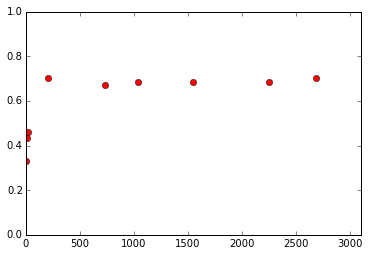

In [22]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    cv = CountVectorizer()
    v_train_data = cv.fit_transform(train_data)
    v_dev_data = cv.transform(dev_data)
    
    num_words = []
    accuracy = []
    
    for cval in [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
        logistic = LogisticRegression(penalty='l1', C=cval, tol=0.01)
        logistic.fit(v_train_data, train_labels)

        #print logistic.coef_ # There appear to be much much more 0 weights

        # Get array of the non zeros for each class
        nparr0 = np.nonzero(logistic.coef_[0])
        nparr1 = np.nonzero(logistic.coef_[1])
        nparr2 = np.nonzero(logistic.coef_[2])
        nparr3 = np.nonzero(logistic.coef_[3])

        # Concatenate the arrays together and get the unique values
        nonzeros = np.concatenate((nparr0[0], nparr1[0], nparr2[0], nparr3[0]))
        nonzeros_unique = list(set(nonzeros))

        # Add the number of features (words) to the num_words array for future plotting
        num_words.append(len(nonzeros_unique))

        v_train_data_pruned = v_train_data[:,nonzeros_unique]
        v_dev_data_pruned  = v_dev_data[:,nonzeros_unique]

        logistic2 = LogisticRegression(penalty='l2', tol=0.01)
        logistic2.fit(v_train_data_pruned, train_labels)
        log2_pred = logistic2.predict(v_dev_data_pruned)
        score = metrics.f1_score(dev_labels, log2_pred, average="weighted")
        
        # Add the score to the accuracy array for plotting
        accuracy.append(score)
        
    print num_words
    print accuracy
    
    plt.plot(num_words, accuracy, 'ro')
    plt.axis([0, 3100, 0, 1])
    plt.show()
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [42]:
def P7():
### STUDENT START ###
    tv = TfidfVectorizer()
    v_train_data = tv.fit_transform(train_data)
    v_dev_data = tv.transform(dev_data)
    
    logistic = LogisticRegression(C=100)
    logistic.fit(v_train_data, train_labels)
    
    R_values = []
    for i in range(len(dev_data)):
        probs = logistic.predict_proba(v_dev_data[i])
        R = max(probs[0])/probs[0][dev_labels[i]]
        R_values.append(R)
    
    npR = np.array(R_values)
    indexes = npR.argsort()[-3:]
    docs = [dev_data[x] for x in indexes]
    
    for i in range(len(docs)):
        print "Predicted label is: %s" % newsgroups_train.target_names[logistic.predict(v_dev_data[indexes[i]])[0]]
        print "Actual label is: %s\n" % newsgroups_train.target_names[dev_labels[indexes[i]]]
        print docs[i]
        print "============================================"
## STUDENT END ###
P7()

Predicted label is: talk.religion.misc
Actual label is: alt.atheism


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

Predicted label is: comp.graphics
Actual label is: talk.religion.misc

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
Predicted label is: comp.graphics
Actual label is: talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words

ANSWER: TfidfVectorizer is different than CountVectorizer in that it normalizes its results.

The three main errors above all have to do with the religion category in one way or another. In the second and third examples, while the fact that they contain "Book of Mormon" should make it clear that they are religion based texts, the fact that there are also many technical words contained in the text is likely throwing off the prediction. One possible way around this would be to include 2grams and 3grams. However, this may make our feature set too large. Another possibility would be to prune certain common words from the features. These would have to be decided based on the context however. Given that these texts come from online posts, perhaps words such as "online" and "internet" could be eliminated in this context.